In [1]:
from bitarray import bitarray
import random
import numpy as np
import math

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import os

In [5]:
from sklearn import datasets

In [6]:
iris = datasets.load_iris()
X = iris.data  
y = iris.target
X = StandardScaler().fit_transform(X)

In [7]:
X.shape

(150, 4)

In [8]:
#first two classes negative, last one positive
x_neg=iris.data[0:100]
x_pos=iris.data[100:150]
np.random.shuffle(x_neg)
x_train = np.concatenate((x_pos, x_neg[0:50])).reshape(-1, 4)
y_train = np.concatenate((np.ones(50), np.zeros(50))).reshape(-1, 1).astype(int)
x_test = np.array(x_neg[50:100]).reshape(-1,4)
y_test = np.zeros(50).reshape(-1,1).astype(int)

In [9]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(100, 4)
(100, 1)
(50, 4)
(50, 1)


# Kraska Hash Model

In [10]:
class Kraska_Hash_BloomFilter:
    
    def __init__(self, size, model): #hash count is 1
        self.size = size
      #  self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        self.model=model #classifier model associated as hash function
        
    def add(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(model.predict(num)[0]*(self.size-1))    
        self.bit_array[result] = 1
            
    def lookup(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(self.model.predict(num)[0]*(self.size-1))    
        if self.bit_array[result] == 0:
                return False
        return True

    def add_init(self,x_train,y_train):
        pred = self.model.predict(x_train)
        for i in range(len(pred)):
            if(y_train[i]==1):
                result = math.floor(pred[i][0]*(self.size-1))
                self.bit_array[result] = 1

    def predict(self,x):
        initpred = self.model.predict(x)
        indexes = []
        for i in range(len(initpred)):
            indexes += [math.floor(initpred[i][0]*(self.size-1))]
        pred = []
        for i in indexes:
            pred += [self.bit_array[i]]
        return np.array(pred)

#adds ratio r of an array of random integers of size n to bloom filter bf(input : bf,size,ratio; output: data array)
def addrandom(bf,n,r):
    data=np.empty(n,dtype=int)
    for i in range(0,n):
        data[i]=random.randint(0, 100000000)
    for j in range(0,int(n*r)):
        bf.add(data[j])
    return data

#(Input:bloom filter,number array,ratio of positives; Output:(-1) for false negative, otherwise fpr)
def fpr_kraska_hash(bf,x_test,y_test):
    pred = bf.predict(x_test)
    tn, fp, fn, tp = confusion_matrix(y_test,pred,labels=[False,True]).ravel() 
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

#(Input:size of bloom filter, number of hash functions, total numbers, ratio of numbers inserted; Output: fpr)
def find_fpr(m,model,n,r):
    bf=Kraska_Hash_BloomFilter(model,m)
    data=addrandom(bf,n,r)
    return fpr(bf,data,r)

#(Input:size of bloom filter, total numbers, ratio of numbers inserted; Output: prints inputs and fpr)
def outputs(m,n,r):
    find_fpr(m,model,n,r)
    #print("For m=%d, k=%d, n=%d, r=%.3f: fpr=%.3f"%(m,k,n,r,find_fpr(m,k,n,r)))

In [11]:
def get_data_points_Kraska(x_train,y_train,x_test,y_test,init_size,diff,num,epochs,fpr_values_kraska,size_values_kraska):
    batch_size = len(x_train)
    input_dim = x_train.shape[1]
    additional_metrics = ['acc']
    loss_function = BinaryCrossentropy()
    optimizer = Adam()
    verbosity_mode = 0
    for i in range(0,num):
        layer_size = init_size + (diff*i)
        number_of_epochs = epochs
        model = Sequential()
        model.add(Dense(layer_size,input_dim=input_dim,activation='relu'))
        model.add(Dense(1,activation='sigmoid'))
        model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
        history = model.fit(x_train, y_train, batch_size = batch_size, epochs=number_of_epochs, verbose=verbosity_mode)

        print("Number of nodes: %d" %(init_size + (diff*i)))
        plt.plot(history.history['acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.show()
        plt.plot(history.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()

        model_size = ((input_dim+1)*layer_size + (layer_size+1))*32

        m = int(model_size/10) + 1
        net_size = model_size + m

        bf=Kraska_Hash_BloomFilter(m,model)
        bf.add_init(x_train,y_train)
        fpr = fpr_kraska_hash(bf,x_test,y_test)

        print("Size: %f bits - FPR: %f \n\n\n" % (net_size,fpr))
        fpr_values_kraska += [fpr]
        size_values_kraska += [net_size]

~~~~~~~~ Iteration 1 ~~~~~~~~ 

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Number of nodes: 1


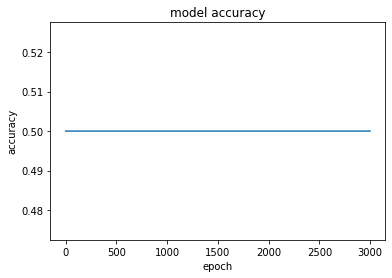

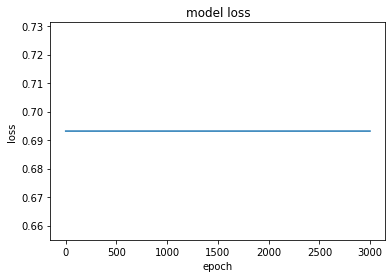

Size: 247.000000 bits - FPR: 1.000000 



Number of nodes: 2


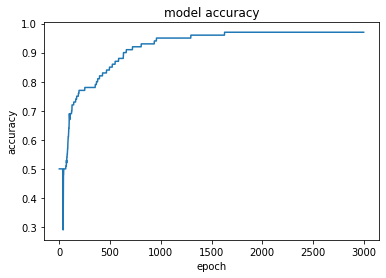

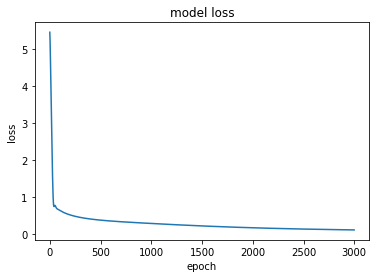

Size: 458.000000 bits - FPR: 0.020000 



Number of nodes: 3


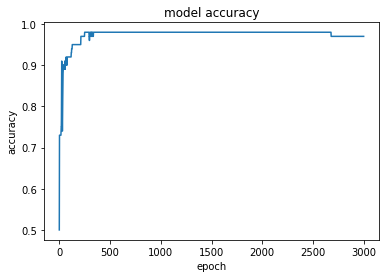

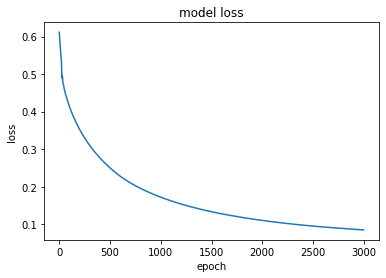

Size: 669.000000 bits - FPR: 0.000000 



Number of nodes: 4


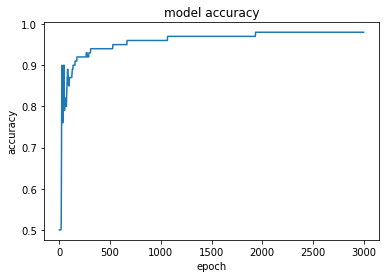

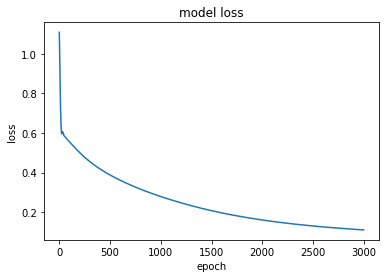

Size: 881.000000 bits - FPR: 0.000000 



Number of nodes: 5


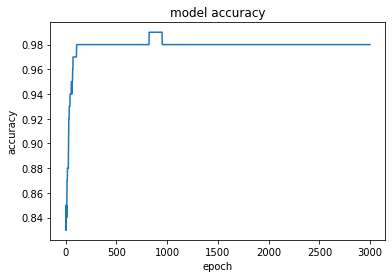

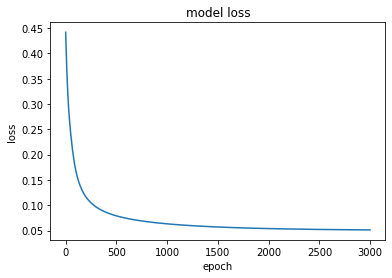

Size: 1092.000000 bits - FPR: 0.000000 



Number of nodes: 6


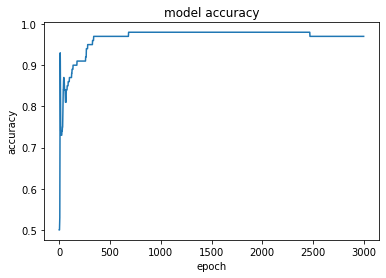

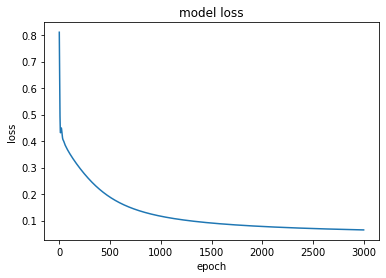

Size: 1303.000000 bits - FPR: 0.000000 



Number of nodes: 7


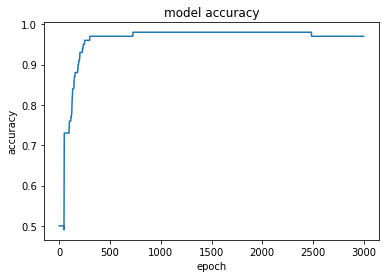

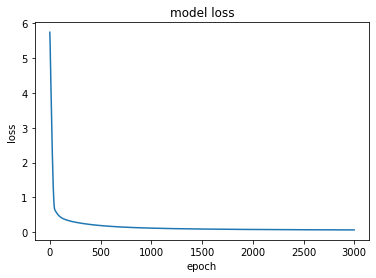

Size: 1514.000000 bits - FPR: 0.020000 



Number of nodes: 8


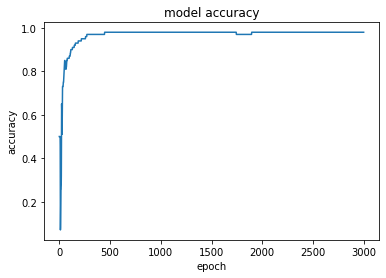

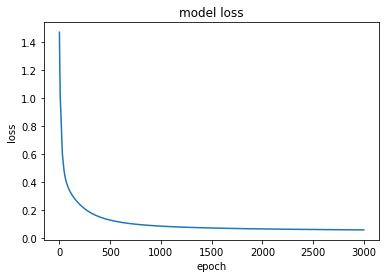

Size: 1725.000000 bits - FPR: 0.000000 



Number of nodes: 9


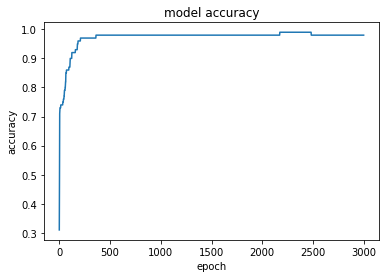

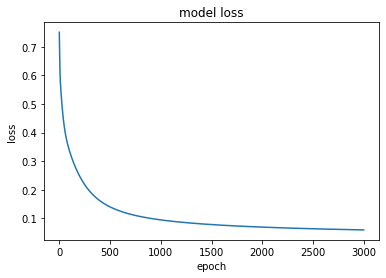

Size: 1937.000000 bits - FPR: 0.000000 



Number of nodes: 10


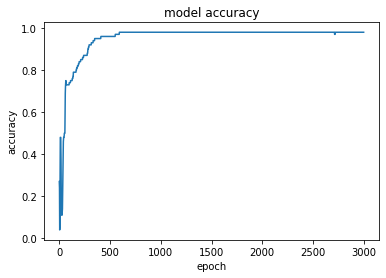

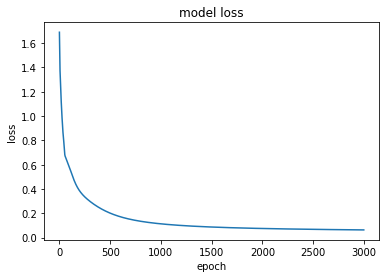

Size: 2148.000000 bits - FPR: 0.000000 



Number of nodes: 11


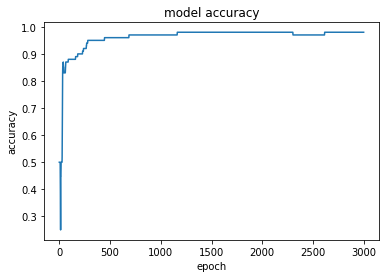

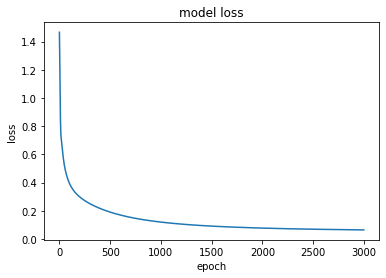

Size: 2359.000000 bits - FPR: 0.000000 



Number of nodes: 12


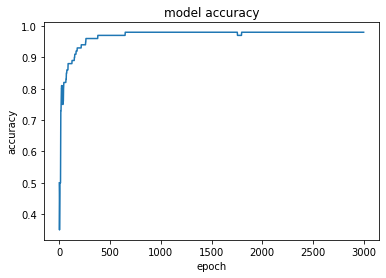

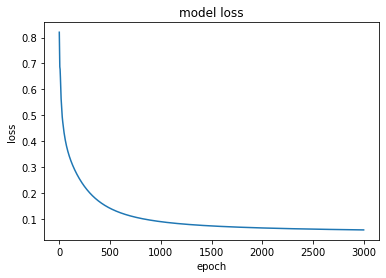

Size: 2570.000000 bits - FPR: 0.000000 



Number of nodes: 13


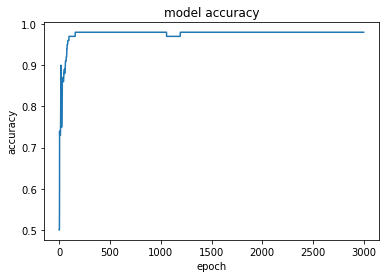

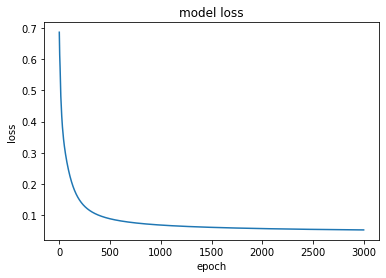

Size: 2781.000000 bits - FPR: 0.000000 



Number of nodes: 14


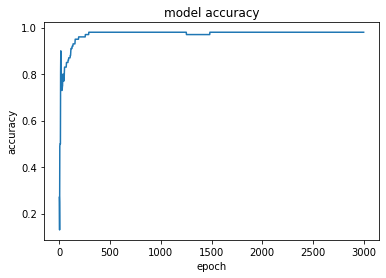

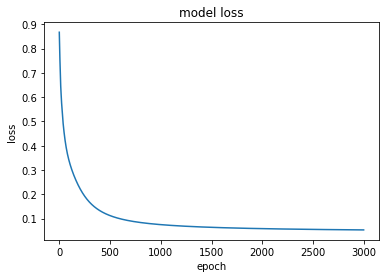

Size: 2993.000000 bits - FPR: 0.000000 



Number of nodes: 15


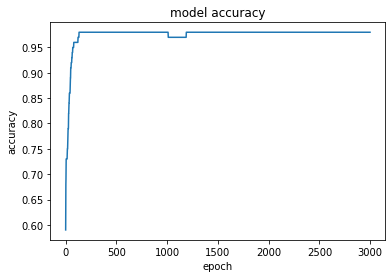

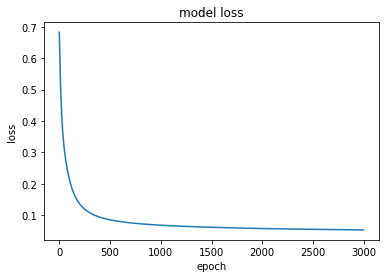

Size: 3204.000000 bits - FPR: 0.000000 



Number of nodes: 16


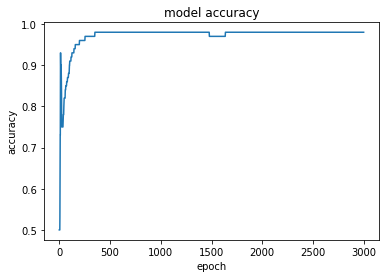

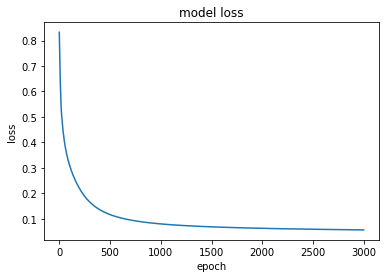

Size: 3415.000000 bits - FPR: 0.000000 



Number of nodes: 17


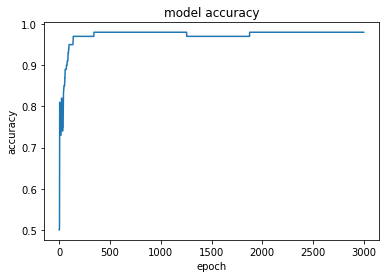

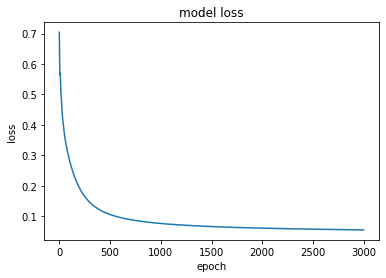

Size: 3626.000000 bits - FPR: 0.000000 



Number of nodes: 18


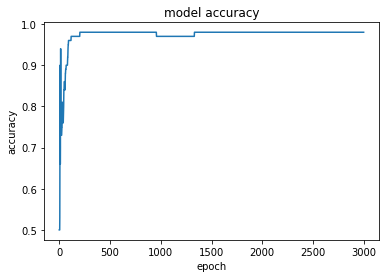

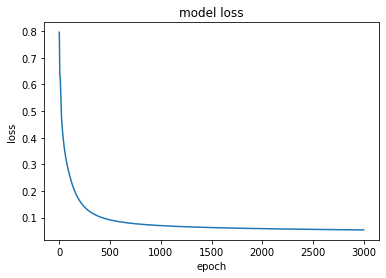

Size: 3837.000000 bits - FPR: 0.000000 



Number of nodes: 19


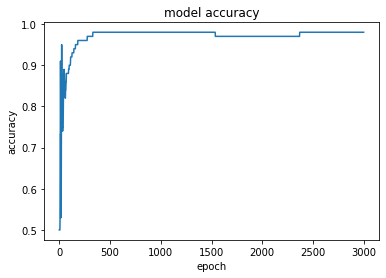

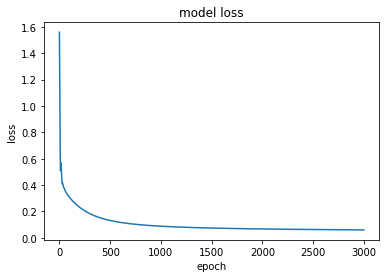

Size: 4049.000000 bits - FPR: 0.000000 



Number of nodes: 20


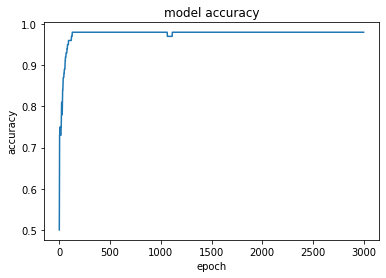

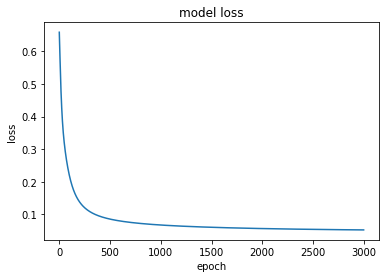

Size: 4260.000000 bits - FPR: 0.000000 



~~~~~~~~ Iteration 2 ~~~~~~~~ 

Number of nodes: 1


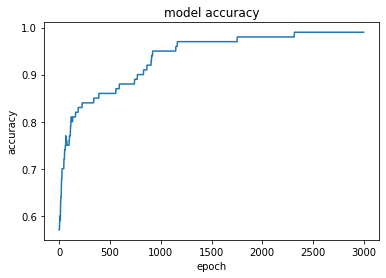

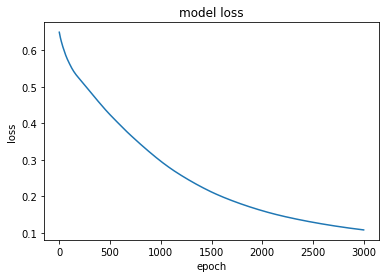

Size: 247.000000 bits - FPR: 0.000000 



Number of nodes: 2


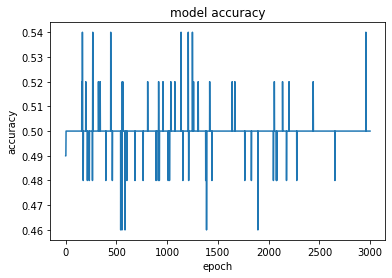

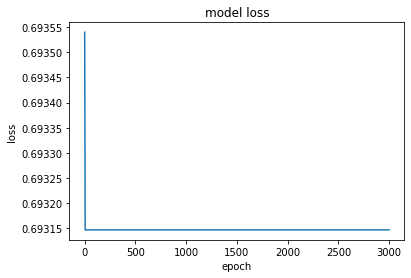

Size: 458.000000 bits - FPR: 1.000000 



Number of nodes: 3


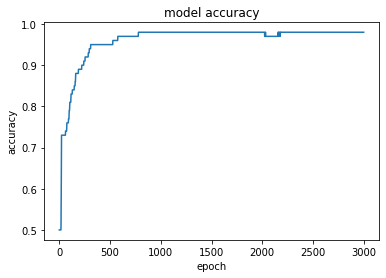

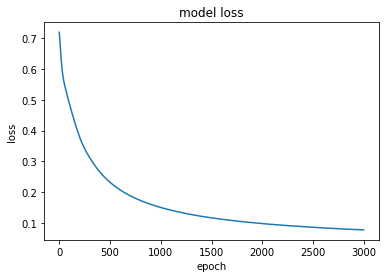

Size: 669.000000 bits - FPR: 0.000000 



Number of nodes: 4


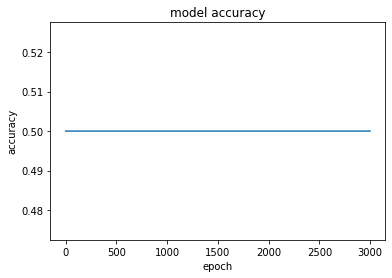

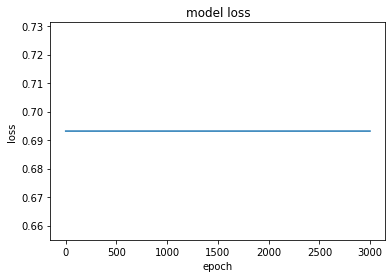

Size: 881.000000 bits - FPR: 1.000000 



Number of nodes: 5


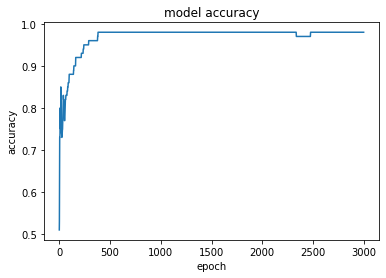

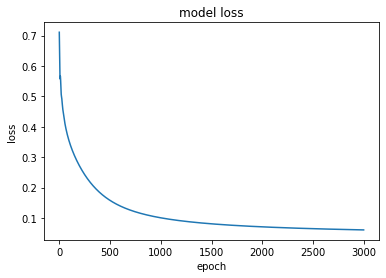

Size: 1092.000000 bits - FPR: 0.000000 



Number of nodes: 6


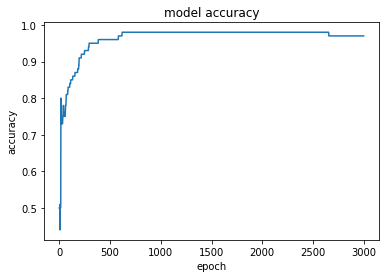

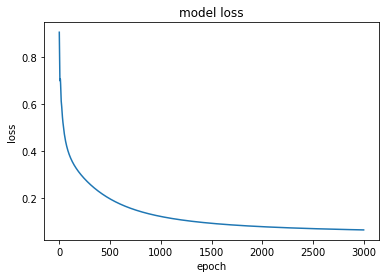

Size: 1303.000000 bits - FPR: 0.000000 



Number of nodes: 7


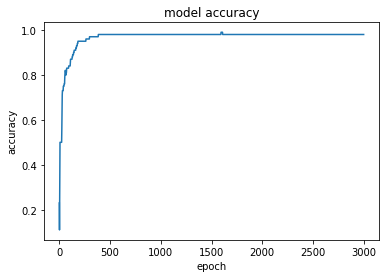

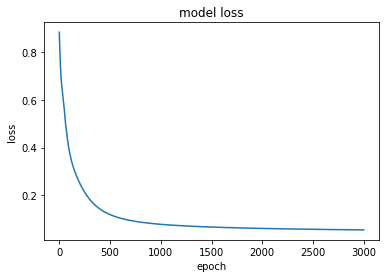

Size: 1514.000000 bits - FPR: 0.000000 



Number of nodes: 8


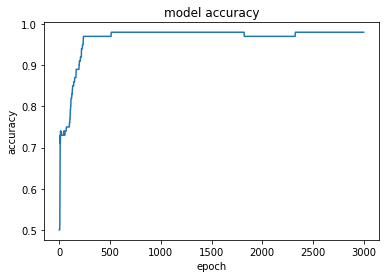

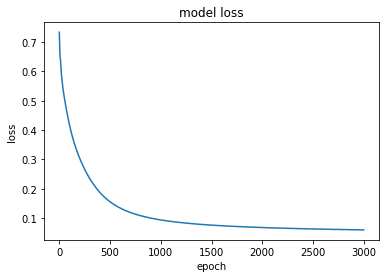

Size: 1725.000000 bits - FPR: 0.000000 



Number of nodes: 9


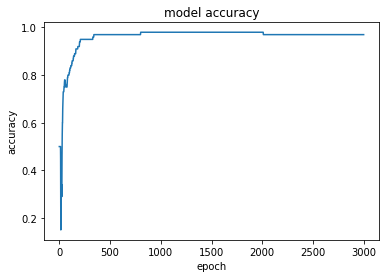

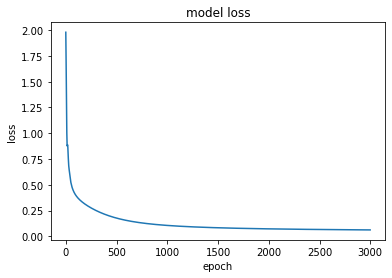

Size: 1937.000000 bits - FPR: 0.000000 



Number of nodes: 10


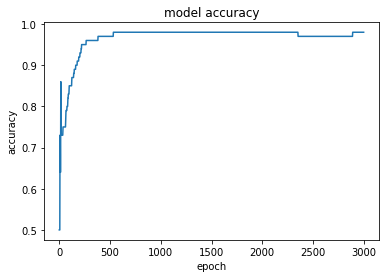

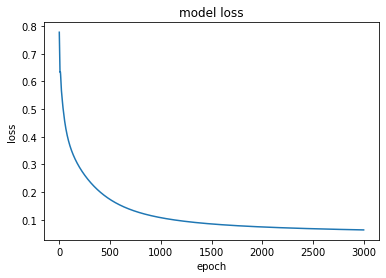

Size: 2148.000000 bits - FPR: 0.000000 



Number of nodes: 11


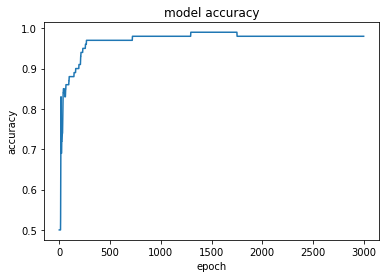

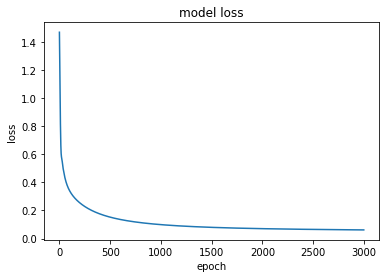

Size: 2359.000000 bits - FPR: 0.000000 



Number of nodes: 12


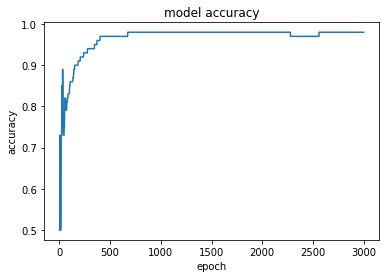

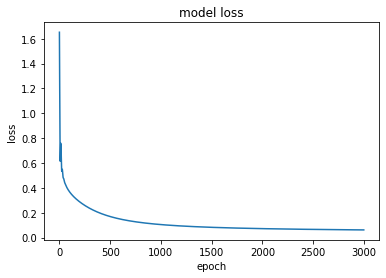

Size: 2570.000000 bits - FPR: 0.000000 



Number of nodes: 13


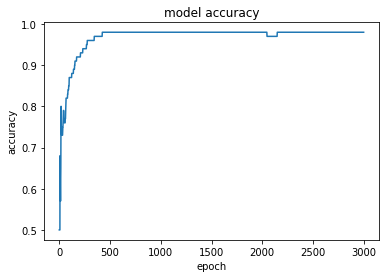

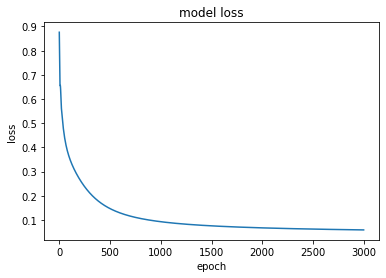

Size: 2781.000000 bits - FPR: 0.000000 



Number of nodes: 14


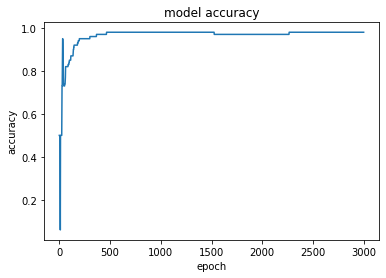

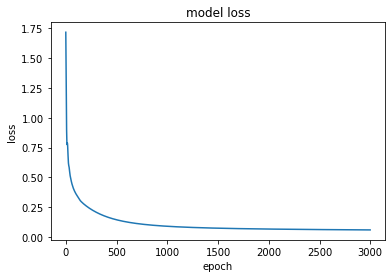

Size: 2993.000000 bits - FPR: 0.020000 



Number of nodes: 15


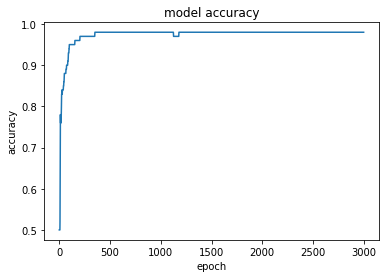

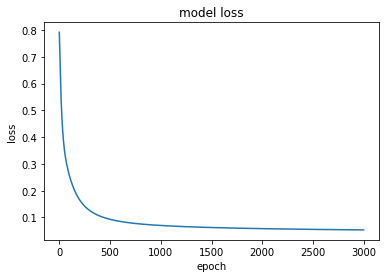

Size: 3204.000000 bits - FPR: 0.000000 



Number of nodes: 16


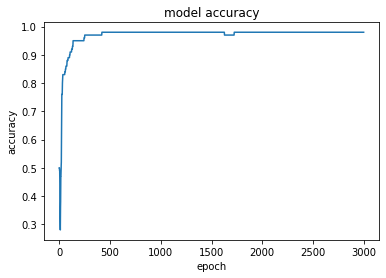

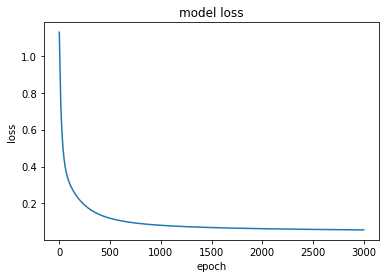

Size: 3415.000000 bits - FPR: 0.000000 



Number of nodes: 17


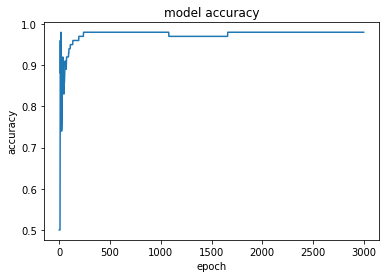

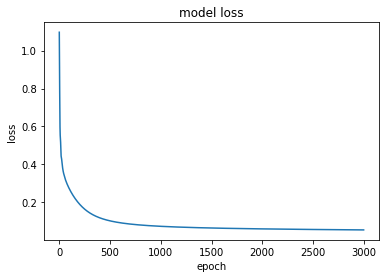

Size: 3626.000000 bits - FPR: 0.000000 



Number of nodes: 18


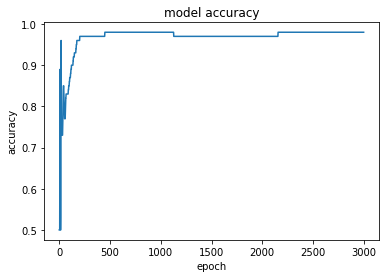

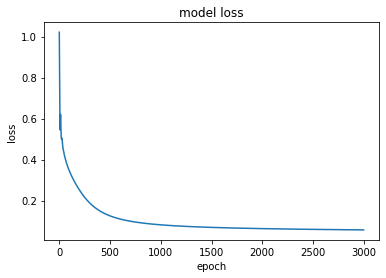

Size: 3837.000000 bits - FPR: 0.000000 



Number of nodes: 19


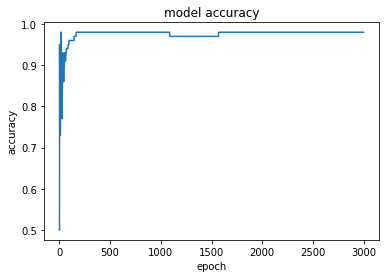

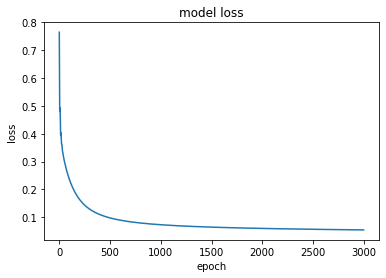

Size: 4049.000000 bits - FPR: 0.000000 



Number of nodes: 20


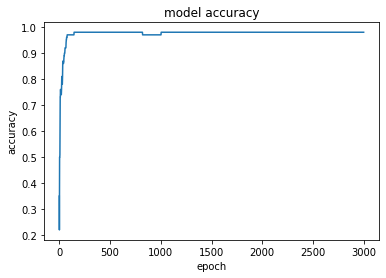

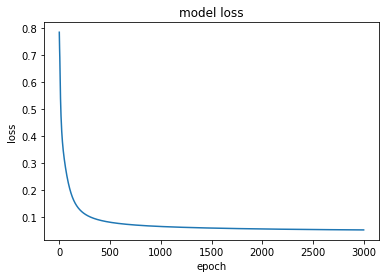

Size: 4260.000000 bits - FPR: 0.000000 



~~~~~~~~ Iteration 3 ~~~~~~~~ 

Number of nodes: 1


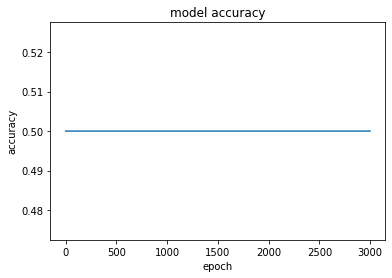

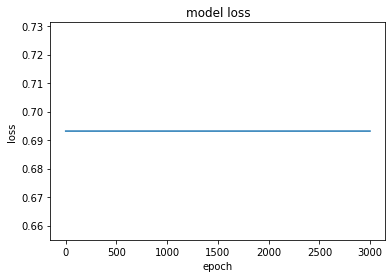

Size: 247.000000 bits - FPR: 1.000000 



Number of nodes: 2


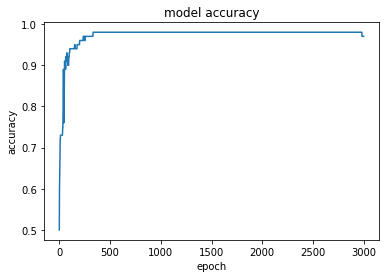

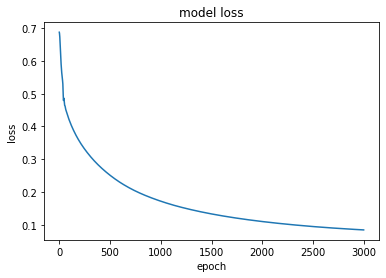

Size: 458.000000 bits - FPR: 0.000000 



Number of nodes: 3


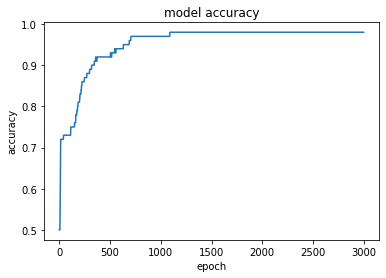

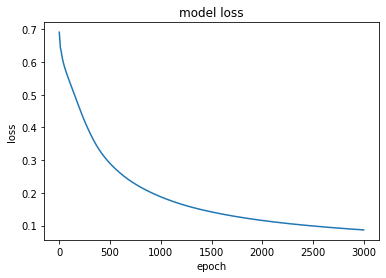

Size: 669.000000 bits - FPR: 0.000000 



Number of nodes: 4


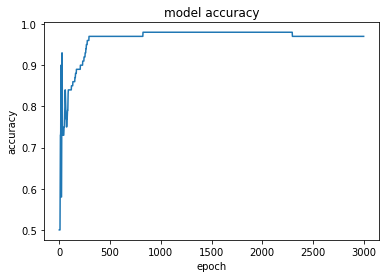

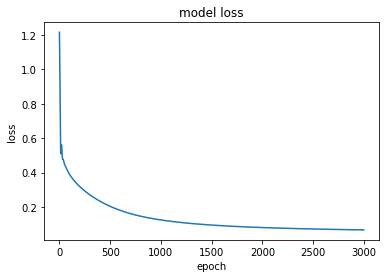

Size: 881.000000 bits - FPR: 0.000000 



Number of nodes: 5


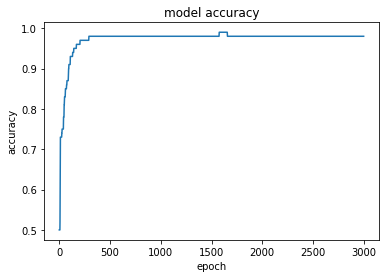

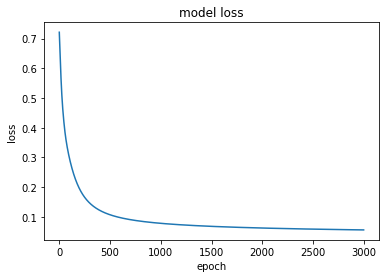

Size: 1092.000000 bits - FPR: 0.000000 



Number of nodes: 6


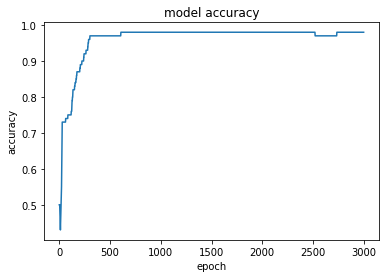

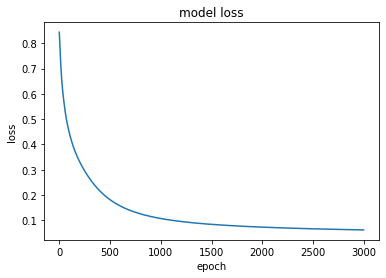

Size: 1303.000000 bits - FPR: 0.000000 



Number of nodes: 7


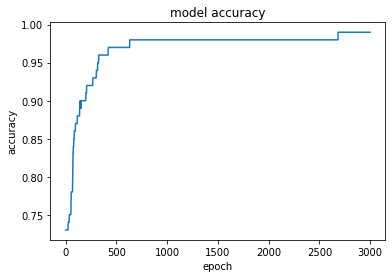

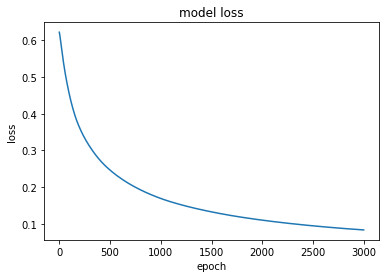

Size: 1514.000000 bits - FPR: 0.000000 



Number of nodes: 8


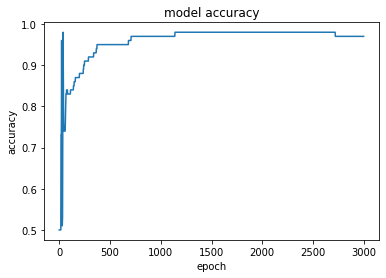

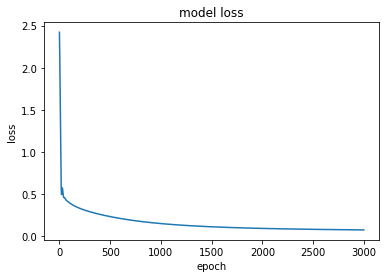

Size: 1725.000000 bits - FPR: 0.000000 



Number of nodes: 9


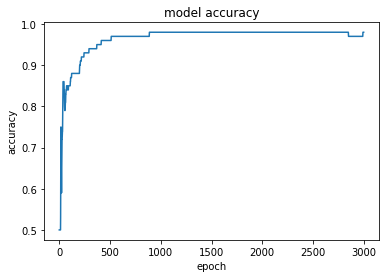

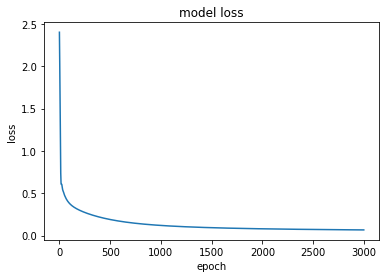

Size: 1937.000000 bits - FPR: 0.000000 



Number of nodes: 10


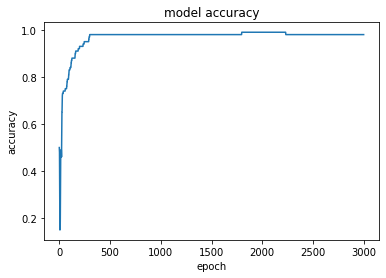

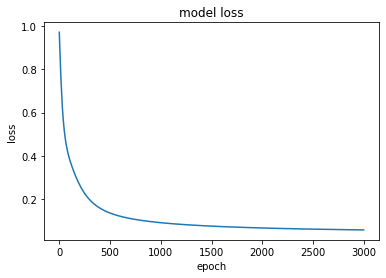

Size: 2148.000000 bits - FPR: 0.000000 



Number of nodes: 11


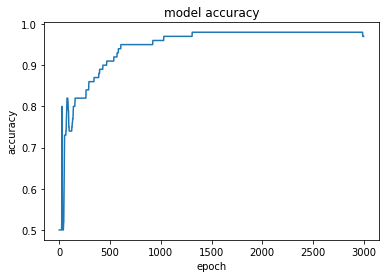

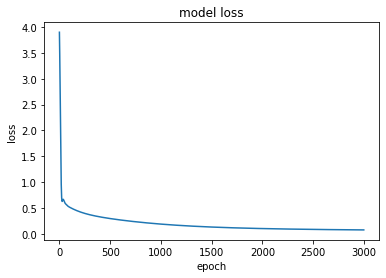

Size: 2359.000000 bits - FPR: 0.000000 



Number of nodes: 12


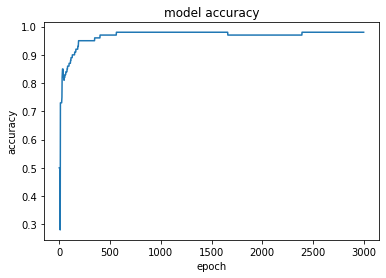

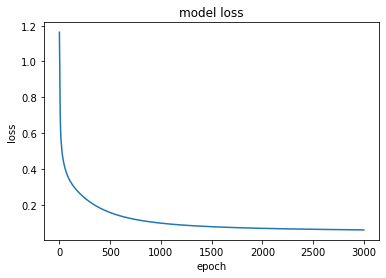

Size: 2570.000000 bits - FPR: 0.000000 



Number of nodes: 13


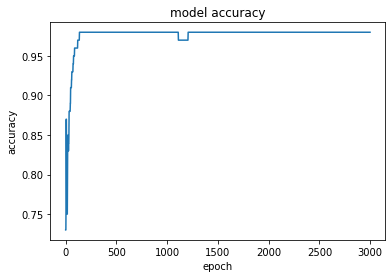

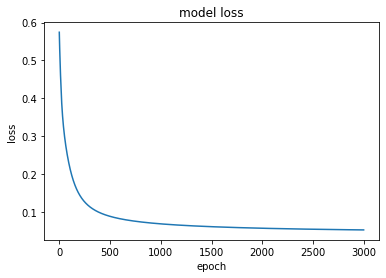

Size: 2781.000000 bits - FPR: 0.000000 



Number of nodes: 14


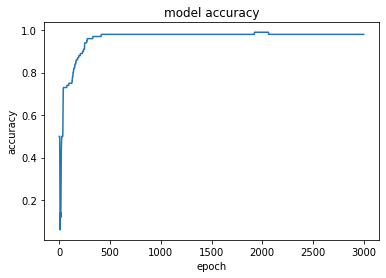

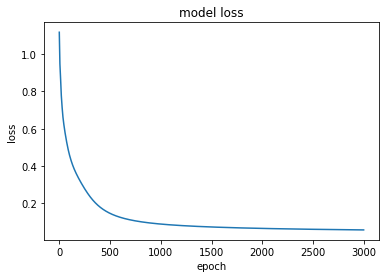

Size: 2993.000000 bits - FPR: 0.000000 



Number of nodes: 15


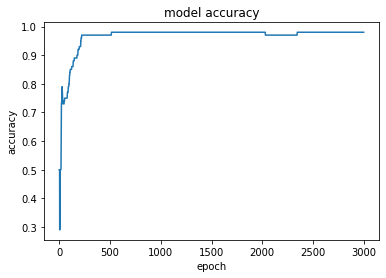

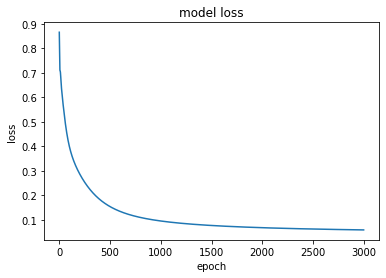

Size: 3204.000000 bits - FPR: 0.000000 



Number of nodes: 16


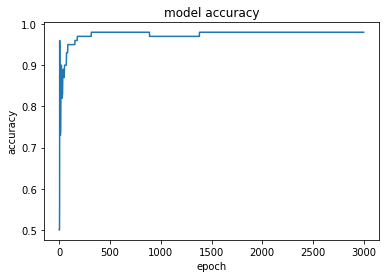

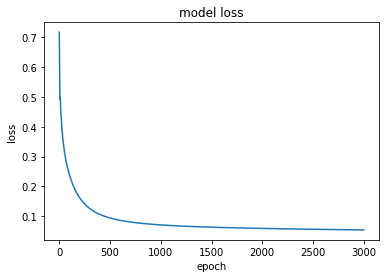

Size: 3415.000000 bits - FPR: 0.000000 



Number of nodes: 17


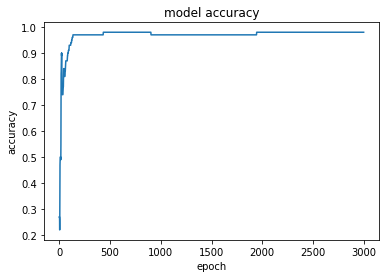

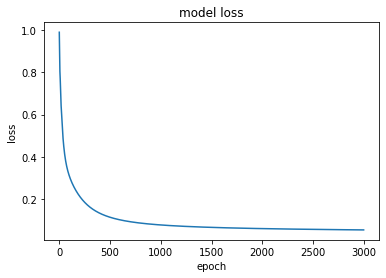

Size: 3626.000000 bits - FPR: 0.000000 



Number of nodes: 18


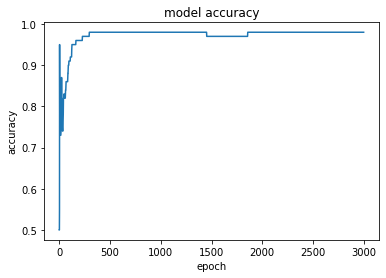

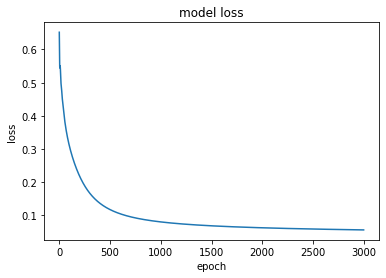

Size: 3837.000000 bits - FPR: 0.000000 



Number of nodes: 19


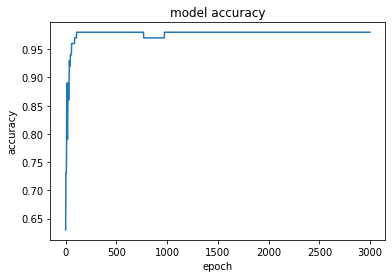

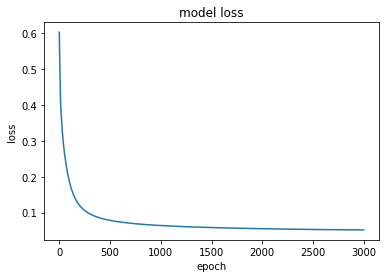

Size: 4049.000000 bits - FPR: 0.000000 



Number of nodes: 20


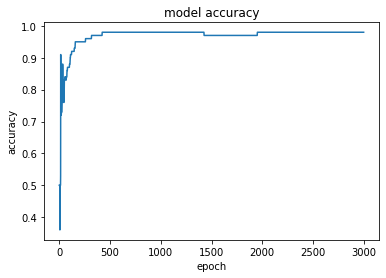

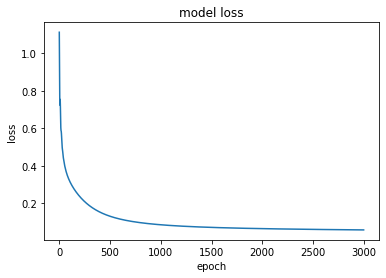

Size: 4260.000000 bits - FPR: 0.000000 





In [12]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values_kraska = []
size_values_kraska = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Kraska(x_train,y_train,x_test,y_test,1,1,20,3000,fpr_values_kraska,size_values_kraska)

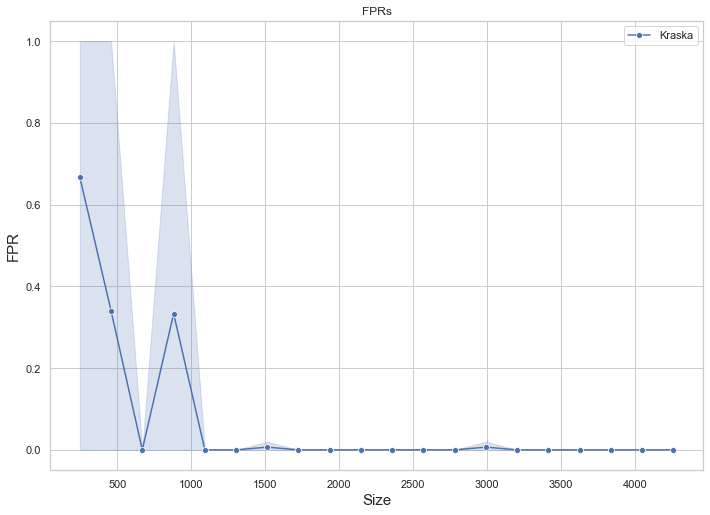

In [13]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values_kraska, y=fpr_values_kraska, err_style="band",label = "Kraska",linewidth = 1.5,marker="o")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# Projection model

In [18]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

In [19]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]
        size_values += [m]

In [20]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values = []
size_values = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,5,10,200,100,fpr_values,size_values)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(50, 4)
Size: 5 Bits - FPR: 0.000000 



Size: 15 Bits - FPR: 0.020000 



Size: 25 Bits - FPR: 0.020000 



Size: 35 Bits - FPR: 0.020000 



Size: 45 Bits - FPR: 0.020000 



Size: 55 Bits - FPR: 0.020000 



Size: 65 Bits - FPR: 0.020000 



Size: 75 Bits - FPR: 0.040000 



Size: 85 Bits - FPR: 0.020000 



Size: 95 Bits - FPR: 0.020000 



Size: 105 Bits - FPR: 0.020000 



Size: 115 Bits - FPR: 0.020000 



Size: 125 Bits - FPR: 0.020000 



Size: 135 Bits - FPR: 0.020000 



Size: 145 Bits - FPR: 0.000000 



Size: 155 Bits - FPR: 0.020000 



Size: 165 Bits - FPR: 0.020000 



Size: 175 Bits - FPR: 0.020000 



Size: 185 Bits - FPR: 0.020000 



Size: 195 Bits - FPR: 0.020000 



Size: 205 Bits - FPR: 0.020000 



Size: 215 Bits - FPR: 0.000000 



Size: 225 Bits - FPR: 0.000000 



Size: 235 Bits - FPR: 0.020000 



Size: 245 Bits - FPR: 0.000000 



Size: 255 Bits - FPR: 0.000000 



Size: 265 Bits - FPR: 0.020000 



Size: 275 Bits - FPR: 0.02

Size: 305 Bits - FPR: 0.000000 



Size: 315 Bits - FPR: 0.000000 



Size: 325 Bits - FPR: 0.000000 



Size: 335 Bits - FPR: 0.000000 



Size: 345 Bits - FPR: 0.020000 



Size: 355 Bits - FPR: 0.000000 



Size: 365 Bits - FPR: 0.000000 



Size: 375 Bits - FPR: 0.020000 



Size: 385 Bits - FPR: 0.000000 



Size: 395 Bits - FPR: 0.020000 



Size: 405 Bits - FPR: 0.000000 



Size: 415 Bits - FPR: 0.000000 



Size: 425 Bits - FPR: 0.000000 



Size: 435 Bits - FPR: 0.000000 



Size: 445 Bits - FPR: 0.020000 



Size: 455 Bits - FPR: 0.000000 



Size: 465 Bits - FPR: 0.000000 



Size: 475 Bits - FPR: 0.000000 



Size: 485 Bits - FPR: 0.000000 



Size: 495 Bits - FPR: 0.000000 



Size: 505 Bits - FPR: 0.000000 



Size: 515 Bits - FPR: 0.000000 



Size: 525 Bits - FPR: 0.020000 



Size: 535 Bits - FPR: 0.000000 



Size: 545 Bits - FPR: 0.000000 



Size: 555 Bits - FPR: 0.000000 



Size: 565 Bits - FPR: 0.000000 



Size: 575 Bits - FPR: 0.000000 



Size: 585 Bits - FPR

Size: 645 Bits - FPR: 0.000000 



Size: 655 Bits - FPR: 0.000000 



Size: 665 Bits - FPR: 0.000000 



Size: 675 Bits - FPR: 0.000000 



Size: 685 Bits - FPR: 0.000000 



Size: 695 Bits - FPR: 0.000000 



Size: 705 Bits - FPR: 0.000000 



Size: 715 Bits - FPR: 0.000000 



Size: 725 Bits - FPR: 0.000000 



Size: 735 Bits - FPR: 0.000000 



Size: 745 Bits - FPR: 0.000000 



Size: 755 Bits - FPR: 0.000000 



Size: 765 Bits - FPR: 0.000000 



Size: 775 Bits - FPR: 0.000000 



Size: 785 Bits - FPR: 0.000000 



Size: 795 Bits - FPR: 0.000000 



Size: 805 Bits - FPR: 0.000000 



Size: 815 Bits - FPR: 0.000000 



Size: 825 Bits - FPR: 0.000000 



Size: 835 Bits - FPR: 0.000000 



Size: 845 Bits - FPR: 0.000000 



Size: 855 Bits - FPR: 0.000000 



Size: 865 Bits - FPR: 0.000000 



Size: 875 Bits - FPR: 0.000000 



Size: 885 Bits - FPR: 0.000000 



Size: 895 Bits - FPR: 0.000000 



Size: 905 Bits - FPR: 0.000000 



Size: 915 Bits - FPR: 0.000000 



Size: 925 Bits - FPR

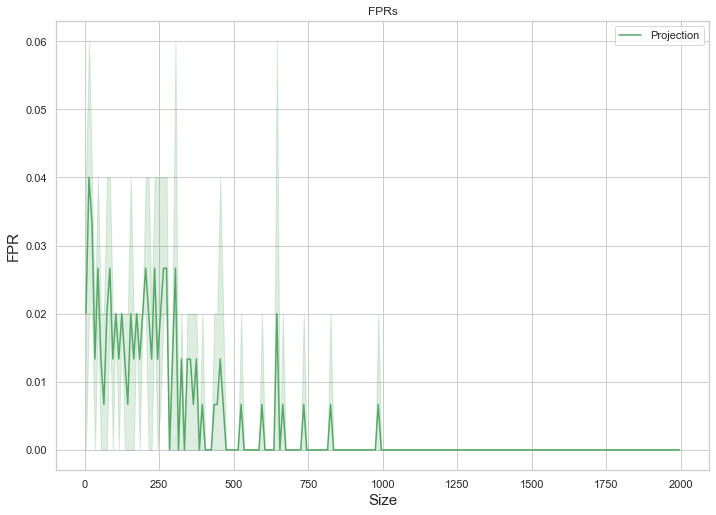

In [21]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# Normal Bloom Filter Values

In [32]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [33]:
print(sum(y_train))
print(len(y_train))

[50]
100


In [36]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

600
[50]


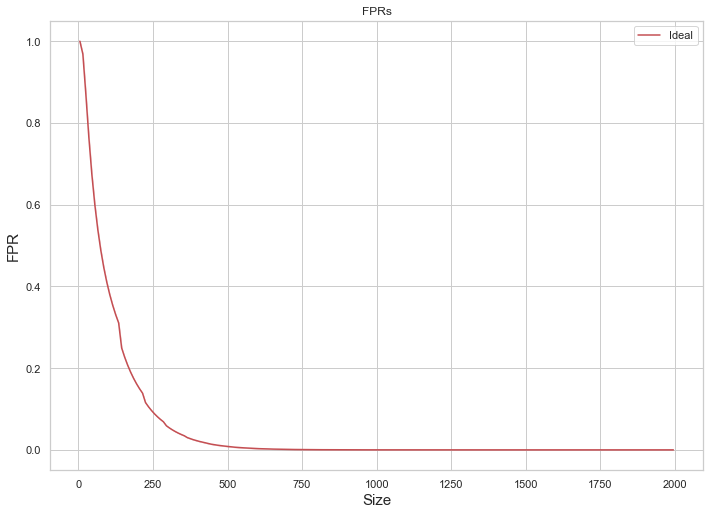

In [37]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# FPR Comparison between Projection Model and Normal Bloom Filter

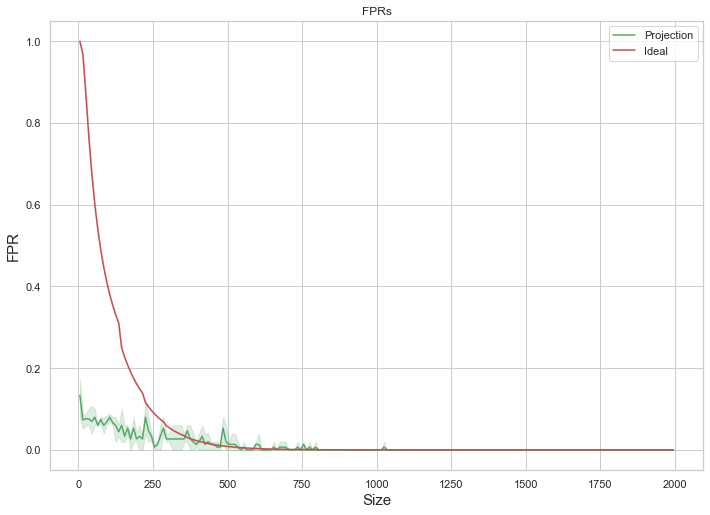

In [38]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# FPR Comparison between all 3 models

In [39]:
def get_data_points_Projection2(x_train,x_test,y_train,epochs,fpr_values,size_values_kraska):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in size_values_kraska:
        m = i
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]

In [41]:
# Ran only once instead of thrice as size_values_kraska already has triple length
fpr_values_projection = []
get_data_points_Projection2(x_train,x_test,y_train,100,fpr_values_projection,size_values_kraska)

(50, 4)
Size: 449 Bits - FPR: 0.020000 



Size: 833 Bits - FPR: 0.000000 



Size: 1217 Bits - FPR: 0.000000 



Size: 1601 Bits - FPR: 0.000000 



Size: 1985 Bits - FPR: 0.000000 



Size: 449 Bits - FPR: 0.000000 



Size: 833 Bits - FPR: 0.000000 



Size: 1217 Bits - FPR: 0.000000 



Size: 1601 Bits - FPR: 0.000000 



Size: 1985 Bits - FPR: 0.000000 



Size: 449 Bits - FPR: 0.060000 



Size: 833 Bits - FPR: 0.020000 



Size: 1217 Bits - FPR: 0.000000 



Size: 1601 Bits - FPR: 0.000000 



Size: 1985 Bits - FPR: 0.000000 





In [42]:
n = sum(y_train)
y_ideal_k=[]
for x in size_values_kraska:
    y_ideal_k+=[float(ideal_fpr(x,n))]
print(len(y_ideal_k))
print(n)


15
[50]


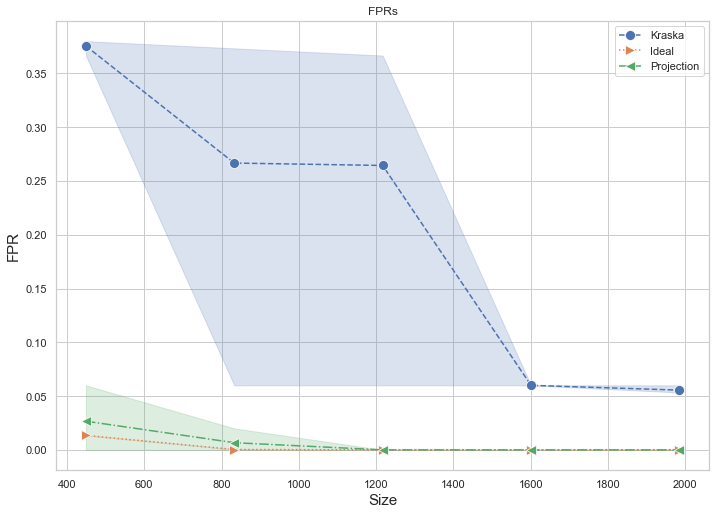

In [43]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values_kraska, y=fpr_values_kraska, err_style="band",marker="o",label = "Kraska",linestyle= "--",markersize=10)
sns.lineplot(x=size_values_kraska, y=y_ideal_k, err_style="band",marker='>',label = "Ideal",linestyle= ":",markersize = 10)
sns.lineplot(x=size_values_kraska, y=fpr_values_projection, err_style="band",marker='<',label = "Projection",linestyle= "-.",markersize = 10)
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

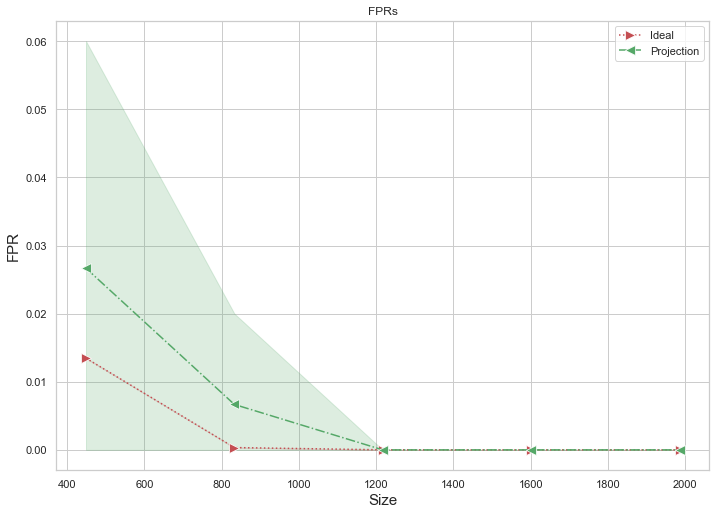

In [44]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values_kraska, y=y_ideal_k, err_style="band",marker='>',label = "Ideal",linestyle= ":",markersize = 10,color="r")
sns.lineplot(x=size_values_kraska, y=fpr_values_projection, err_style="band",marker='<',label = "Projection",linestyle= "-.",markersize = 10,color="g")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

#  Projection Model with only 1 Hash Function

In [ ]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = 1  #Setting k as 1
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]
        size_values += [m]

In [ ]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values = []
size_values = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,5,10,200,100,fpr_values,size_values)

In [ ]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# Projection Model with Kernel and lesser no of vectors

In [65]:
from sklearn.kernel_approximation import RBFSampler

In [75]:
class Projection_BloomFilter_new:
    def __init__(self, size, dim):
        vectors = np.random.normal(0,1,size=(1,dim)) #random vectors(each row) from normal distribution, not unit vectors 
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        rbf_feature = RBFSampler(gamma=1, random_state=1)
        projections = rbf_feature.fit_transform(X)
        projections2 = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

In [87]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        fpr = 1
        tempbf = Projection_BloomFilter_new(m,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter_new(m,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        #print(tempbf.give_hash_values(x_train),"train")
        #print(tempbf.give_hash_values(x_test),"test")
        fpr_values += [fpr_test]
        size_values += [m]

In [80]:
def get_data_points_Projection2(x_train,x_test,y_train,epochs,fpr_values,size_values_kraska):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in size_values_kraska:
        m = i
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]


In [88]:
fpr_values=[]
size_values=[]

In [89]:
get_data_points_Projection(x_train,x_test,y_train,5,10,200,100,fpr_values,size_values)

(50, 4)
Size: 5 Bits - FPR: 0.000000 



Size: 15 Bits - FPR: 0.000000 



Size: 25 Bits - FPR: 0.000000 



Size: 35 Bits - FPR: 0.000000 



Size: 45 Bits - FPR: 0.000000 



Size: 55 Bits - FPR: 0.000000 



Size: 65 Bits - FPR: 0.000000 



Size: 75 Bits - FPR: 0.000000 



Size: 85 Bits - FPR: 0.000000 



Size: 95 Bits - FPR: 0.000000 



Size: 105 Bits - FPR: 0.000000 



Size: 115 Bits - FPR: 0.000000 



Size: 125 Bits - FPR: 0.000000 



Size: 135 Bits - FPR: 0.000000 



Size: 145 Bits - FPR: 0.000000 



Size: 155 Bits - FPR: 0.000000 



Size: 165 Bits - FPR: 0.000000 



Size: 175 Bits - FPR: 0.000000 



Size: 185 Bits - FPR: 0.000000 



Size: 195 Bits - FPR: 0.000000 



Size: 205 Bits - FPR: 0.000000 



Size: 215 Bits - FPR: 0.000000 



Size: 225 Bits - FPR: 0.000000 



Size: 235 Bits - FPR: 0.000000 



Size: 245 Bits - FPR: 0.000000 



Size: 255 Bits - FPR: 0.000000 



Size: 265 Bits - FPR: 0.000000 



Size: 275 Bits - FPR: 0.000000 



Size: 285 Bits - FPR: 0

In [90]:
get_data_points_Projection(x_train,x_test,y_train,5,10,200,100,fpr_values,size_values)

(50, 4)
Size: 5 Bits - FPR: 0.000000 



Size: 15 Bits - FPR: 0.000000 



Size: 25 Bits - FPR: 0.000000 



Size: 35 Bits - FPR: 0.000000 



Size: 45 Bits - FPR: 0.000000 



Size: 55 Bits - FPR: 0.000000 



Size: 65 Bits - FPR: 0.000000 



Size: 75 Bits - FPR: 0.000000 



Size: 85 Bits - FPR: 0.000000 



Size: 95 Bits - FPR: 0.000000 



Size: 105 Bits - FPR: 0.000000 



Size: 115 Bits - FPR: 0.000000 



Size: 125 Bits - FPR: 0.000000 



Size: 135 Bits - FPR: 0.000000 



Size: 145 Bits - FPR: 0.000000 



Size: 155 Bits - FPR: 0.000000 



Size: 165 Bits - FPR: 0.000000 



Size: 175 Bits - FPR: 0.000000 



Size: 185 Bits - FPR: 0.000000 



Size: 195 Bits - FPR: 0.000000 



Size: 205 Bits - FPR: 0.000000 



Size: 215 Bits - FPR: 0.000000 



Size: 225 Bits - FPR: 0.000000 



Size: 235 Bits - FPR: 0.000000 



Size: 245 Bits - FPR: 0.000000 



Size: 255 Bits - FPR: 0.000000 



Size: 265 Bits - FPR: 0.000000 



Size: 275 Bits - FPR: 0.000000 



Size: 285 Bits - FPR: 0